# Dataset analysis

## Common premable

In [6]:
import os, sys
sys.path.append(os.path.join(os.path.abspath(''), '../'))

import peewee as pw
from toyDb.databases import ExperimentDb, ShaderDb
from toyDb.utils.Directory import getToyDbRootDir

import matplotlib.pyplot as plt
import numpy as np
import json
from tqdm import tqdm
import torch

ExperimentDb.init_from_default_db()

## experiments.db & ShaderDb analysis

In [7]:
shaderDB = ShaderDb.ShaderDB(os.path.join(getToyDbRootDir(), "shaders"))
shaderDB.scan_local()
shaderDB.load_all()

all_shaders = set(shaderDB.offlineShaders.keys())
imageonly_shaders = shaderDB.filter_attribute(["is_imageonly"])

# all environments available in database
all_environments = ExperimentDb.Environment.select()

# shaders that have at least 1 non-error measurement
measurable_shaders = set([shdr.shader_id for shdr in ExperimentDb.ImageOnlyShader.select(
      ExperimentDb.ImageOnlyShader.shader_id
    ).join(ExperimentDb.ImageOnlyExperiment).where(
      ExperimentDb.ImageOnlyExperiment.errors == ExperimentDb.ErrorType.NONE,
    ).distinct()
])

# shaders that have measurements in all working environments
all_measurable_shaders = set([shdr.shader_id for shdr in ExperimentDb.ImageOnlyShader.select(
      ExperimentDb.ImageOnlyShader.shader_id
    ).join(ExperimentDb.ImageOnlyExperiment).group_by(
      ExperimentDb.ImageOnlyShader.shader_id
    ).having(
      pw.fn.MAX(ExperimentDb.ImageOnlyExperiment.errors) == 0
    )
])

measurable_and_traceable_shaders = set([shdr.shader_id for shdr in ExperimentDb.ImageOnlyShader.select(
      ExperimentDb.ImageOnlyShader.shader_id
    ).join(ExperimentDb.ImageOnlyExperiment).where(
      ExperimentDb.ImageOnlyExperiment.errors == ExperimentDb.ErrorType.NONE,
      ExperimentDb.ImageOnlyExperiment.trace.is_null(False)
    ).distinct()
])

all_measurable_and_traceable_shaders = set([shdr.shader_id for shdr in ExperimentDb.ImageOnlyShader.select(
      ExperimentDb.ImageOnlyShader.shader_id
    ).join(ExperimentDb.ImageOnlyExperiment).group_by(
      ExperimentDb.ImageOnlyShader.shader_id
    ).having(
      pw.fn.MAX(ExperimentDb.ImageOnlyExperiment.errors) == 0,
      pw.fn.SUM(ExperimentDb.ImageOnlyExperiment.trace.is_null(True)) == 0
    )
])

all_measurable_and_traceable_canonical_shaders = set([shdr.shader_id for shdr in ExperimentDb.ImageOnlyShader.select(
      ExperimentDb.ImageOnlyShader.shader_id
    ).join(ExperimentDb.ImageOnlyExperiment).where(
      ExperimentDb.ImageOnlyExperiment.num_cycles == ExperimentDb.CANONICAL_NUM_CYCLES,
      ExperimentDb.ImageOnlyExperiment.num_trials == ExperimentDb.CANONICAL_NUM_TRIALS,
      ExperimentDb.ImageOnlyExperiment.width == ExperimentDb.CANONICAL_WIDTH,
      ExperimentDb.ImageOnlyExperiment.height == ExperimentDb.CANONICAL_HEIGHT
    ).group_by(
      ExperimentDb.ImageOnlyShader.shader_id
    ).having(
      pw.fn.MAX(ExperimentDb.ImageOnlyExperiment.errors) == 0,
      pw.fn.SUM(ExperimentDb.ImageOnlyExperiment.trace.is_null(True)) == 0
    )
])

In [8]:
print(f"Number of shaders in Shadertoy Offline Database: {len(all_shaders)}")
print(f"Number of ImageOnly shaders: {len(imageonly_shaders)}")
print(f"Number of environments: {len(all_environments)}")

print(f"Number of measurable shaders: {len(measurable_shaders)}")
print(f"Number of all measurable shaders: {len(all_measurable_shaders)}")
print(f"Number of measurable and traceable shaders: {len(measurable_and_traceable_shaders)}")
print(f"Number of all measurable and traceable shaders: {len(all_measurable_and_traceable_shaders)}")
print(f"Number of all measurable and traceable canonical experimented shaders: {len(all_measurable_and_traceable_canonical_shaders)}")


Number of shaders in Shadertoy Offline Database: 0
Number of ImageOnly shaders: 0
Number of environments: 2
Number of measurable shaders: 14239
Number of all measurable shaders: 14239
Number of measurable and traceable shaders: 14237
Number of all measurable and traceable shaders: 14216
Number of all measurable and traceable canonical experimented shaders: 14217


In [9]:
measurable_shaders - measurable_and_traceable_shaders

{'Nd33Dr', 'wltGWs'}

## Distribution analysis

There are several impact factors on training, including
- distribution of time
- distribution of trace count
- distribution of number of SPIR-V instructions
- distribution of number of tokens in tokenized shaders

The analysis is done for 3060 environment.

In [10]:
environment_selected = all_environments[1]
print(f"Environment selected: {environment_selected.node} - {environment_selected.cpu} - {environment_selected.gpu} - {environment_selected.gpu_driver}")

Environment selected: libreliu-GCL-Arch -  Intel(R) Core(TM) i7-10700K CPU @ 3.80GHz - AMD Radeon RX 6600 XT (RADV NAVI23) - radv Mesa 23.2.1-arch1.2


In [14]:
# Select experiments where shaderIDs match the shaderID provided, and
# return the first if have multiple record
shader_to_experiment = {}
query = ExperimentDb.ImageOnlyExperiment.select(
      ExperimentDb.ImageOnlyExperiment
    ).where(
      # Canonical condition
      ExperimentDb.ImageOnlyExperiment.num_cycles == ExperimentDb.CANONICAL_NUM_CYCLES,
      ExperimentDb.ImageOnlyExperiment.num_trials == ExperimentDb.CANONICAL_NUM_TRIALS,
      ExperimentDb.ImageOnlyExperiment.width == ExperimentDb.CANONICAL_WIDTH,
      ExperimentDb.ImageOnlyExperiment.height == ExperimentDb.CANONICAL_HEIGHT,
      # Inside all_measurable_and_traceable_canonical_shaders
      ExperimentDb.ImageOnlyExperiment.environment == environment_selected,
      ExperimentDb.ImageOnlyExperiment.errors == 0
    ).order_by(
      ExperimentDb.ImageOnlyExperiment.shader_shadertoy_id
    )

# To debug the SQL command use this
# print(query)
  
for expr in query:
  shader_id = expr.shader_shadertoy_id
  if shader_id not in all_measurable_and_traceable_canonical_shaders:
    continue

  if shader_id not in shader_to_experiment:
    shader_to_experiment[shader_id] = expr

print(f"Number of experiment selected: {len(shader_to_experiment)}")


Number of experiment selected: 14054


In [15]:
timeResults = np.ndarray((len(shader_to_experiment), ExperimentDb.CANONICAL_NUM_TRIALS), dtype=np.float64)
shaderIds = []
for idx, (shaderId, expr) in enumerate(shader_to_experiment.items()):
    if expr.results == "":
        raise Exception(f"[{idx}] id={expr.id} doesn't have results")
    timeResults[idx, :] = json.loads(expr.results)
    shaderIds.append(shaderId)

shaderIds = np.array(shaderIds)
timeMean = np.mean(timeResults, axis=1)
timeStdev = np.std(timeResults, axis=1)

indices = np.argsort(timeMean)
timeMean = timeMean[indices]
timeStdev = timeStdev[indices]
shaderIds = shaderIds[indices]

### Distribution of time measured

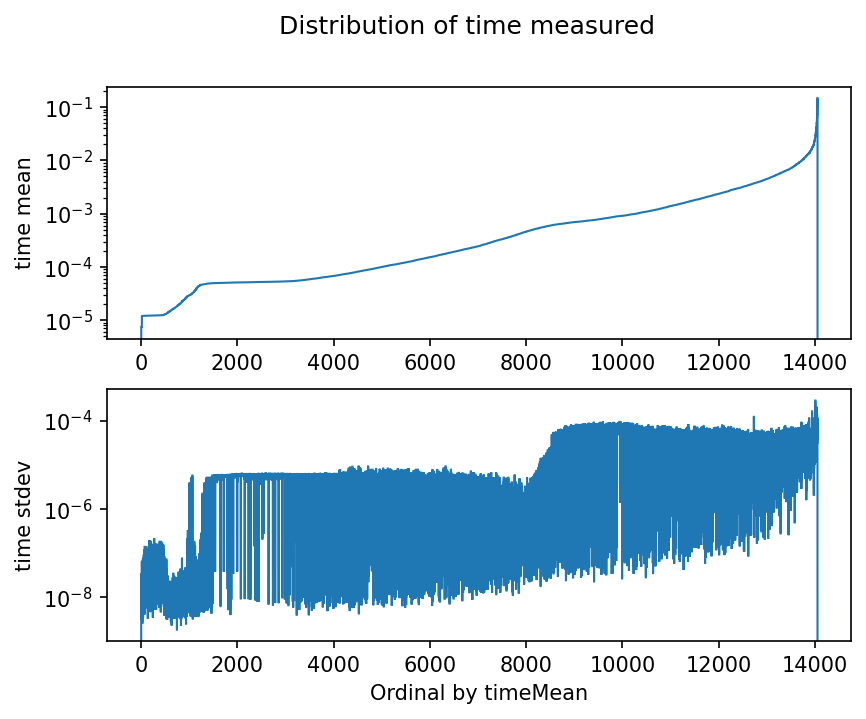

In [16]:
plt.rcParams['figure.dpi'] = 150
fig, (ax1, ax2) = plt.subplots(2, 1)
fig.suptitle(f"Distribution of time measured")

ax1.stairs(timeMean)

# ax1.set_xlabel('Ordinal by timeMean')
ax1.set_ylabel('time mean')
ax1.set_yscale('log')

# ax2.bar([i for i in range(0, len(timeStdev))], timeStdev)
ax2.stairs(timeStdev)

ax2.set_xlabel('Ordinal by timeMean')
ax2.set_ylabel('time stdev')
ax2.set_yscale('log')

plt.show()

Statistics by slot used in metrics.

分为如下几组：
- `time >= 1e-1 sec` (也就是 `fps <= 10`)
- `1e-2 <= time < 1e-1` (也就是 `10 <= fps <= 100`)
- `1e-3 <= time < 1e-2` (也就是 `100 <= fps <= 1000`)
- `1e-4 <= time < 1e-3` (也就是 `1000 <= fps <= 10000`)
- `time < 1e-4` (也就是 `10000 < fps`)

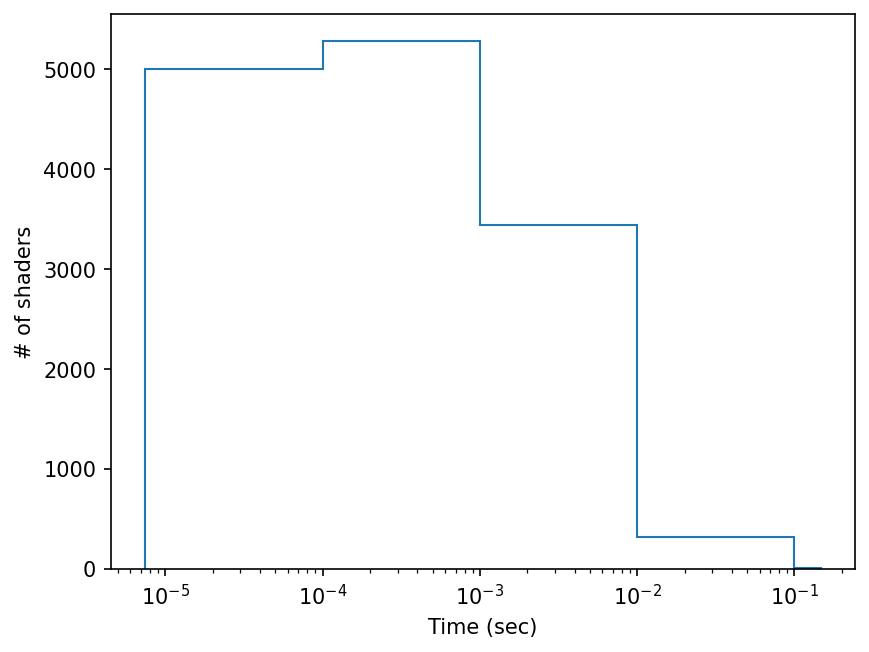

In [17]:
separationPoint = [np.min(timeMean), 1e-4, 1e-3, 1e-2, 1e-1, np.max(timeMean)]
hist, binEdges = np.histogram(timeMean, bins=separationPoint)

fig, ax = plt.subplots()
ax.stairs(hist, binEdges)
ax.set_xscale('log')
ax.set_xlabel('Time (sec)')
ax.set_ylabel('# of shaders')
plt.show()

#### Normalized time comparison

- Mean-Stdev Normalizer
- LogPlusNormalizer

Normalizer name 'Normalizer', mean=-9.060001298435317e-16, stdev=0.9999644223072024
First 10 values: [-0.3393158  -0.33931032 -0.33930996 -0.33930993 -0.33930944 -0.33930695
 -0.33930662 -0.33930639 -0.33930614 -0.33930545];
Last 10 values: [15.25243132 16.39406214 17.29166399 17.95836743 20.40511829 21.75921455
 24.50728655 24.99302876 25.28928742 35.57846013]


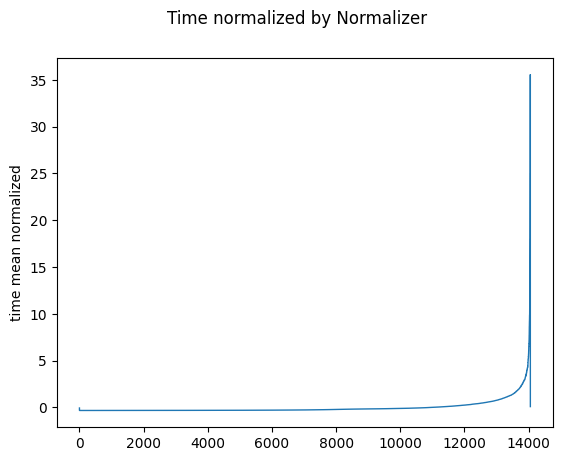

NOTE: No need to build from samples for LogPlusNormalizer
Normalizer name 'LogPlusNormalizer', mean=0.0013929778825559594, stdev=0.004004044261087188
First 10 values: [7.39103935e-06 7.41357252e-06 7.41503918e-06 7.41517251e-06
 7.41717249e-06 7.42743908e-06 7.42877241e-06 7.42970573e-06
 7.43077239e-06 7.43357237e-06];
Last 10 values: [0.06212505 0.06652524 0.06997132 0.07252327 0.08183332 0.08694873
 0.09725046 0.09906038 0.10016266 0.13771037]


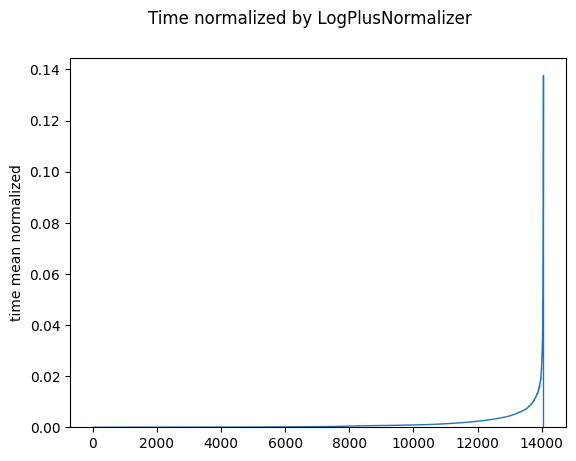

NOTE: No need to build from samples for LogNormalizer
Normalizer name 'LogNormalizer', mean=-8.120511775201749, stdev=1.7925559542153555
First 10 values: [-11.81523849 -11.81219441 -11.81199659 -11.81197861 -11.81170893
 -11.81032572 -11.81014622 -11.81002059 -11.80987703 -11.80950029];
Last 10 values: [-2.74738267 -2.67672688 -2.62448018 -2.58736701 -2.46187508 -2.39864726
 -2.28144635 -2.26208673 -2.25046053 -1.91295735]


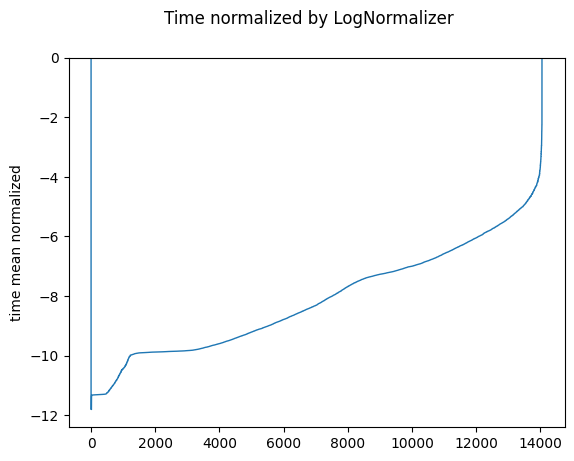

In [18]:
from misc.normalization import Normalizer, LogPlusNormalizer, LogNormalizer

def sampleIterator():
    numSamples = len(timeMean)
    for i in range(0, numSamples):
        yield timeMean[i]

# Mean-stdev normalizer
for normalizerCls in (Normalizer, LogPlusNormalizer, LogNormalizer):
    if hasattr(normalizerCls, 'buildFromSamples'):
        normalizer = normalizerCls.buildFromSamples(sampleIterator())
    else:
        print(f"NOTE: No need to build from samples for {normalizerCls.__name__}")
        normalizer = normalizerCls()
    normalizedMean = normalizer.normalize(timeMean)
    print(f"Normalizer name '{normalizerCls.__name__}', mean={np.mean(normalizedMean)}, stdev={np.std(normalizedMean)}")

    print(f"First 10 values: {normalizedMean[:10]};\nLast 10 values: {normalizedMean[-10:]}")

    plt.rcParams['figure.dpi'] = 100
    fig, ax = plt.subplots()
    fig.suptitle(f"Time normalized by {normalizerCls.__name__}")

    ax.stairs(normalizedMean)

    # ax1.set_xlabel('Ordinal by timeMean')
    ax.set_ylabel('time mean normalized')
    # ax.set_yscale('log')
    plt.show()


> Stair graph's first segment comes from (0, 0), so the graph itself is ok.

In [19]:
print(f"original time statistics: mean={np.mean(timeMean)} std={np.std(timeMean)}") 

original time statistics: mean=0.0014021080412361842 std=0.00411023402331357


### Distribution of basic block trace count

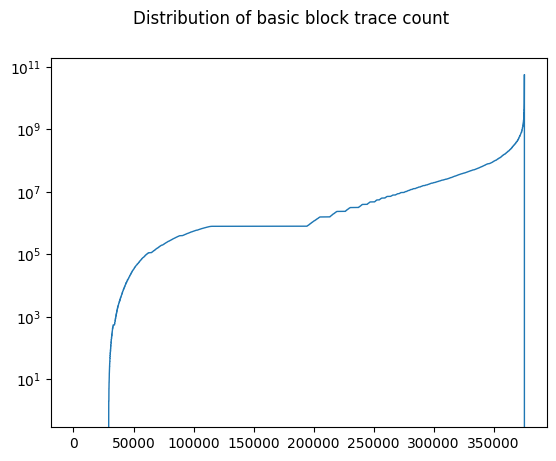

In [20]:
bbTraceCounts = []

for shaderId, expr in shader_to_experiment.items():
  bbTraceCounters = json.loads(expr.trace.bb_trace_counters)
  bbTraceCounts += bbTraceCounters

bbTraceCounts = np.array(bbTraceCounts, dtype=np.uint64)
bbTraceCounts = np.sort(bbTraceCounts)

fig, ax = plt.subplots()
fig.suptitle('Distribution of basic block trace count')

ax.stairs(bbTraceCounts)
ax.set_yscale('log')

plt.show()

In [21]:
print(f"Maximum value: {np.max(bbTraceCounts):.10e}")

Maximum value: 5.6726812590e+10


#### Test for normalizer impact on trace count

Normalizer name 'Normalizer', mean=-3.0993999517296e-16, stdev=0.9999986688169716
First 10 values: [-0.12651227 -0.12651227 -0.12651227 -0.12651227 -0.12651227 -0.12651227
 -0.12651227 -0.12651227 -0.12651227 -0.12651227];
Last 10 values: [ 68.2055801   68.2055801   68.2055801   68.47354909  68.47354909
  74.38667497 108.91438697 125.40957944 125.40957944 193.16453715]


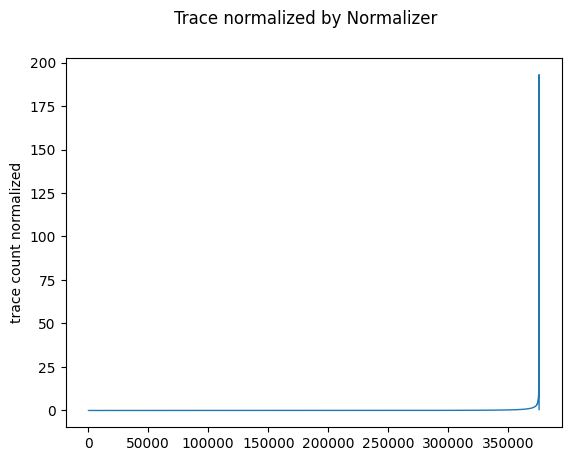

NOTE: No need to build from samples for LogPlusNormalizer
Normalizer name 'LogPlusNormalizer', mean=13.413233525202951, stdev=4.710077640935295
First 10 values: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.];
Last 10 values: [23.72169527 23.72169527 23.72169527 23.72560917 23.72560917 23.80829186
 24.18903877 24.32990904 24.32990904 24.76151282]


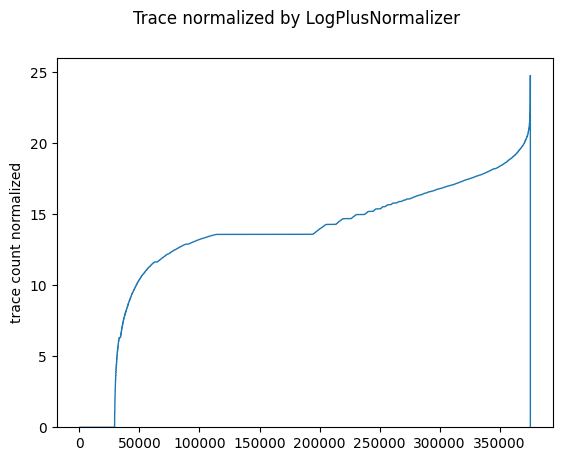

NOTE: No need to build from samples for LogNormalizer


c:\Projects\NGPP\vkPredict\notebooks\..\misc\normalization.py:95: RuntimeWarning: divide by zero encountered in log
  return np.log(sample)
c:\Projects\NGPP\venv\lib\site-packages\numpy\core\_methods.py:236: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


Normalizer name 'LogNormalizer', mean=-inf, stdev=nan
First 10 values: [-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf];
Last 10 values: [23.72169527 23.72169527 23.72169527 23.72560917 23.72560917 23.80829186
 24.18903877 24.32990904 24.32990904 24.76151282]


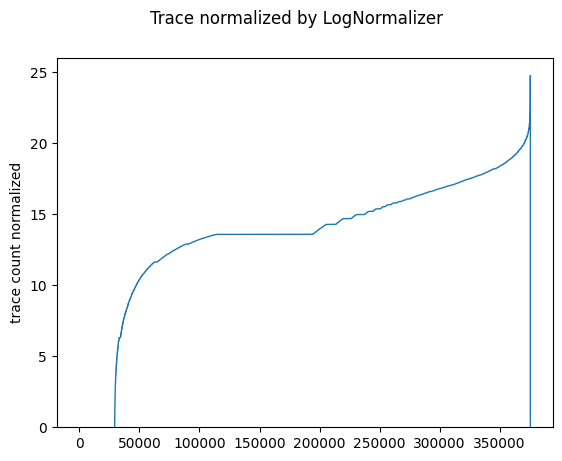

In [22]:
def sampleIterator():
    numSamples = len(bbTraceCounts)
    for i in range(0, numSamples):
        yield bbTraceCounts[i]

# Mean-stdev normalizer
for normalizerCls in (Normalizer, LogPlusNormalizer, LogNormalizer):
    if hasattr(normalizerCls, 'buildFromSamples'):
        normalizer = normalizerCls.buildFromSamples(sampleIterator())
    else:
        print(f"NOTE: No need to build from samples for {normalizerCls.__name__}")
        normalizer = normalizerCls()
    normalizedTraceCount = normalizer.normalize(bbTraceCounts)
    print(f"Normalizer name '{normalizerCls.__name__}', mean={np.mean(normalizedTraceCount)}, stdev={np.std(normalizedTraceCount)}")

    print(f"First 10 values: {normalizedTraceCount[:10]};\nLast 10 values: {normalizedTraceCount[-10:]}")

    plt.rcParams['figure.dpi'] = 100
    fig, ax = plt.subplots()
    fig.suptitle(f"Trace normalized by {normalizerCls.__name__}")

    ax.stairs(normalizedTraceCount)

    # ax1.set_xlabel('Ordinal by timeMean')
    ax.set_ylabel('trace count normalized')
    # ax.set_yscale('log')
    plt.show()

Test for occurance count on using binary encoding

In [23]:
def do_onehot_base2(trace_labels_raw: torch.Tensor, d_embed: int, shifted=False) -> 'torch.Tensor':
    bsz, seq_len = trace_labels_raw.size()
    trace_labels = trace_labels_raw.to(dtype=torch.int64, device=trace_labels_raw.device)
    ones = torch.ones((d_embed,), dtype=torch.int64, device=trace_labels.device)

    # (d_embed, )
    masks = torch.bitwise_left_shift(ones, torch.arange(d_embed, device=trace_labels.device))
    trace_embeds = (torch.bitwise_and(trace_labels.view(bsz, seq_len, 1), masks.view(1, 1, d_embed)) > 0).float()
    if shifted:
        trace_embeds -= 0.5

    return trace_embeds

trace_labels = torch.as_tensor(bbTraceCounts.astype(dtype=np.int64)).unsqueeze(0)
print(trace_labels.size())

trace_embeds = do_onehot_base2(trace_labels, 64).squeeze()
print(trace_embeds.size())

summed = torch.sum(trace_embeds, dim=0, dtype=torch.int64)
print(summed.size())
print(summed)

print(torch.sum((summed > 0).int()))
print(torch.nonzero(summed)[-1])

torch.Size([1, 375606])
torch.Size([375606, 64])
torch.Size([64])
tensor([ 74400,  84661,  90703,  92056,  93350,  93201,  94043,  94734,  95792,
         95359,  95972,  96632,  98170,  97032,  93603,  95005,  93901,  90402,
        181009, 184135,  94222,  90797,  73106,  60768,  48047,  35143,  22935,
         12806,   7032,   3463,   1265,    488,    123,     35,     20,      3,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0])
tensor(36)
tensor([35])


所以，看起来可以测试测试 `` 选择 37，33，30 下的表现

## Token related

The output dictionary for HfSpvTokenizer contains:
- `input_ids`
- `trace_labels`

...and other encoded keys for padding purpose

Note that we use a configuration equivalent to `HfTracedSpvTokenizer-multiple-entrypoint`.

Also, validate every tokenized shader begins with `[BOS]`.

In [24]:
from misc.HfTracedSpvTokenizer import HfTracedSpvTokenizer

tokenizer = HfTracedSpvTokenizer(
  single_entrypoint=False,
  compact_types=False,
  convert_ext_insts=False  
)

shaderTokenizedLength = []
exhaustiveIDSpaceShaderIds = []
for idx, (shaderId, expr) in tqdm(enumerate(shader_to_experiment.items())):
  try:
    tokenized = tokenizer(
      spvBinaryRepr=expr.shader.fragment_spv,
      id2TraceIdxMap={int(k): v for k, v in json.loads(expr.trace.bb_idx_map).items()},
      traceCounters=json.loads(expr.trace.bb_trace_counters)
    )

    if tokenized["input_ids"][0] != tokenizer.get_command("[BOS]"):
      raise Exception("[BOS] not present in the beginning of the tokenized shader")

    shaderTokenizedLength.append(len(tokenized["input_ids"]))
  except RuntimeError as e:
    if "Id exceed max available length" in e.__str__():
      exhaustiveIDSpaceShaderIds.append(shaderId)
    else:
      raise

shaderTokenizedLength = np.array(shaderTokenizedLength)
print(f"Successfully tokenized: {len(shaderTokenizedLength)}")
print(f"Failed to tokenize because of exhaustive ID space usage: {exhaustiveIDSpaceShaderIds}")

14054it [08:32, 27.41it/s]

Successfully tokenized: 14053
Failed to tokenize because of exhaustive ID space usage: ['fl2yzG']


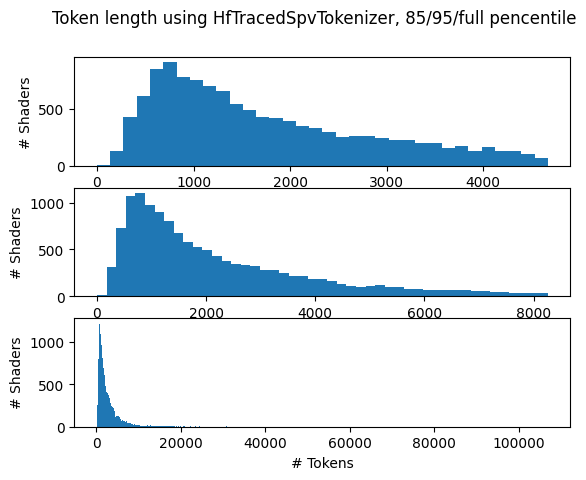

In [25]:
plt.rcParams['figure.dpi'] = 100
fig, (ax1, ax2, ax3) = plt.subplots(3, 1)
fig.suptitle(f"Token length using {tokenizer.__class__.__name__}, 85/95/full pencentile")
    
max_85 = np.percentile(shaderTokenizedLength, 85)
max_95 = np.percentile(shaderTokenizedLength, 95)
ax1.hist(shaderTokenizedLength, bins='auto', range=(0, max_85))
# ax1.set_xlabel('# SPIR-V instructions')
ax1.set_ylabel('# Shaders')
    
ax2.hist(shaderTokenizedLength, bins='auto', range=(0, max_95))
ax2.set_xlabel("# Tokens")
ax2.set_ylabel('# Shaders')

ax3.hist(shaderTokenizedLength, bins='auto')
ax3.set_xlabel("# Tokens")
ax3.set_ylabel('# Shaders')

plt.show()

In [26]:
print(f"Percentiles:")
for cutPoint in [95, 90, 85, 80, 75]:
  print(f"- {cutPoint}%: {np.percentile(shaderTokenizedLength, cutPoint)}")

Percentiles:
- 95%: 8261.8
- 90%: 5870.0
- 85%: 4669.399999999998
- 80%: 3866.2000000000007
- 75%: 3331.0


Test for the cut point we chose

In [27]:
for cutPoint in [1024, 4096]:
  count = np.sum(shaderTokenizedLength <= cutPoint)
  print(f"- <={cutPoint}: {count} ({count / len(shaderTokenizedLength) * 100}% of the original)")

- <=1024: 4037 (28.72696221447378% of the original)
- <=4096: 11485 (81.72632178182594% of the original)


### TODO: Test for type and ExtInst compaction